<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy

In [3]:
import cv2

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
image_path = 'images/objects/train'
max_dim = (256, 256, 3)
enhance_flag = False

kernel = numpy.array([[-1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

In [8]:
def read_image_file(my_image_file, enhanced=False):
    global max_dim, kernel, alpha, beta
    
    _fish_image = cv2.imread(my_image_file, cv2.COLOR_BGR2RGB)
    
    if enhanced:
        _fish_image = cv2.filter2D(_fish_image, -1, kernel)
        _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)

    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2])
    
    return _fish_image

In [9]:
def show_image(my_image):
    global max_dim
    
    _my_image = numpy.reshape(my_image, max_dim)
    
    fig, ax = plt.subplots(dpi=120)
    
    ax.imshow(my_image)
    ax.axis('off')
    
    plt.show()

<h3>載入魚影像檔</h3>

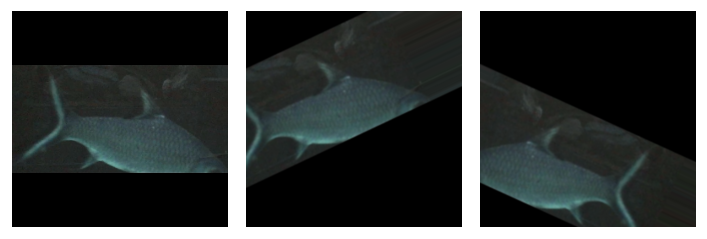

In [10]:
datagen = ImageDataGenerator(rotation_range=45,
                             width_shift_range=[0.1, 0.2],
                             height_shift_range=[0.1, 0.2],
                             horizontal_flip=True)

_fish_image = read_image_file('%s/F000079-00001.jpg' % image_path, enhance_flag)

fig, ax = plt.subplots(dpi=120, ncols=3)

ax[0].imshow(_fish_image)
ax[0].axis('off')

_fish_img_data = img_to_array(_fish_image)    
_fish_img_data = numpy.expand_dims(_fish_img_data, 0)

it = datagen.flow(_fish_img_data, batch_size=1)

for i in range(1, 3):
    _batch = it.next()
    _generated_image = _batch[0].astype('uint8')
            
    ax[i].imshow(_generated_image, cmap='gray', interpolation='bicubic')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [11]:
def load_data(image_path, train_ratio=0.8, enhanced=False):
    global max_dim

    datagen = ImageDataGenerator(rotation_range=45,
                                 width_shift_range=[0.1, 0.2],
                                 height_shift_range=[0.1, 0.2],
                                 horizontal_flip=True
    )
    
    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')
        
        _fish_image = read_image_file(_image_file, enhanced)
        
        my_images.append(numpy.reshape(_fish_image, max_dim))

        _fish_img_data = img_to_array(_fish_image)    
        _fish_img_data = numpy.expand_dims(_fish_img_data, 0)
        
        it = datagen.flow(_fish_img_data, batch_size=1)

        for i in range(10):
            _batch = it.next()
            _generated_image = _batch[0].astype('uint8')
            
            my_images.append(numpy.reshape(_generated_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)
    
    pos = int(my_images.shape[0] * train_ratio)
    return my_images[:pos], my_images[pos:]

In [12]:
x_train, x_test = load_data(image_path, 0.8, enhance_flag)

In [13]:
x_train.shape, x_test.shape

((4488, 256, 256, 3), (1122, 256, 256, 3))

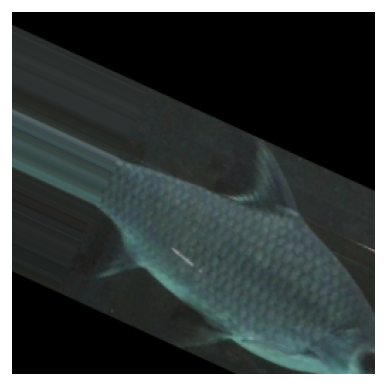

In [14]:
show_image(x_train[numpy.random.randint(len(x_train))])

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>參數設置</h3>
<p>$$壓縮率: \frac {{256}*{256}={65536}}{64} = 1024$$</p>

<h3>建立模型</h3>

In [16]:
input_img = keras.Input(shape=max_dim, name='input')

In [17]:
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv2D_256')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_256')(x)

In [18]:
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_128')(x)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_128')(x)

In [19]:
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_64')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name='latent')(x)

In [20]:
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='Conv2DT_64')(encoded)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_64')(x)

In [21]:
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='Conv2DT_128')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_128')(x)

In [22]:
x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', name='Conv2DT_256')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_256')(x)

In [23]:
decoded = layers.Conv2D(max_dim[-1], (3, 3), padding='same', name='output')(x)

In [24]:
autoencoder = keras.Model(input_img, decoded)

In [25]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_256 (Conv2D)          (None, 256, 256, 256)     7168      
_________________________________________________________________
MaxPooling2D_256 (MaxPooling (None, 128, 128, 256)     0         
_________________________________________________________________
Conv2D_128 (Conv2D)          (None, 128, 128, 128)     295040    
_________________________________________________________________
MaxPooling2D_128 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
Conv2D_64 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
latent (MaxPooling2D)        (None, 32, 32, 64)       

In [26]:
autoencoder.compile(optimizer='adam', loss='mse')  # binary_crossentropy

<h3>訓練模型</h3>

In [27]:
checkpointer = ModelCheckpoint(
    filepath='CNN-C-0-256-128.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [28]:
num_of_epoch = 512
num_of_batch_size = 8

In [29]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/512
561/561 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00001: val_loss improved from inf to 0.00016, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 48s 85ms/step - loss: 0.0010 - val_loss: 1.5537e-04
Epoch 2/512
561/561 [==============================] - ETA: 0s - loss: 1.5923e-04
Epoch 00002: val_loss improved from 0.00016 to 0.00012, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 47s 84ms/step - loss: 1.5923e-04 - val_loss: 1.2094e-04
Epoch 3/512
561/561 [==============================] - ETA: 0s - loss: 1.2116e-04
Epoch 00003: val_loss improved from 0.00012 to 0.00011, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 48s 85ms/step - loss: 1.2116e-04 - val_loss: 1.0574e-04
Epoch 4/512
561/561 [==============================] - ETA: 0s - loss: 1.3897e-04
Epoch 00004: val_loss improved from 0.00011 to 0.00011, saving model to CNN-C-0-256-128.hdf5
561/561 [======

Epoch 33/512
561/561 [==============================] - ETA: 0s - loss: 5.7517e-05
Epoch 00033: val_loss did not improve from 0.00005
561/561 [==============================] - 47s 85ms/step - loss: 5.7517e-05 - val_loss: 5.3469e-05
Epoch 34/512
561/561 [==============================] - ETA: 0s - loss: 5.9920e-05
Epoch 00034: val_loss did not improve from 0.00005
561/561 [==============================] - 47s 85ms/step - loss: 5.9920e-05 - val_loss: 5.8453e-05
Epoch 35/512
561/561 [==============================] - ETA: 0s - loss: 6.4491e-05
Epoch 00035: val_loss improved from 0.00005 to 0.00005, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 47s 85ms/step - loss: 6.4491e-05 - val_loss: 5.2796e-05
Epoch 36/512
561/561 [==============================] - ETA: 0s - loss: 5.7006e-05
Epoch 00036: val_loss improved from 0.00005 to 0.00005, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 47s 85ms/step - loss: 5.7006e-05 - val_l

Epoch 67/512
561/561 [==============================] - ETA: 0s - loss: 4.8990e-05
Epoch 00067: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.8990e-05 - val_loss: 4.4301e-05
Epoch 68/512
561/561 [==============================] - ETA: 0s - loss: 4.6489e-05
Epoch 00068: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 85ms/step - loss: 4.6489e-05 - val_loss: 4.4715e-05
Epoch 69/512
561/561 [==============================] - ETA: 0s - loss: 5.3236e-05
Epoch 00069: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 5.3236e-05 - val_loss: 5.8045e-05
Epoch 70/512
561/561 [==============================] - ETA: 0s - loss: 7.7170e-05
Epoch 00070: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 7.7170e-05 - val_loss: 5.3390e-05
Epoch 71/512
561/561 [==============================] - ETA: 0s - lo

Epoch 102/512
561/561 [==============================] - ETA: 0s - loss: 4.8736e-05
Epoch 00102: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.8736e-05 - val_loss: 4.6652e-05
Epoch 103/512
561/561 [==============================] - ETA: 0s - loss: 4.9158e-05
Epoch 00103: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.9158e-05 - val_loss: 4.5488e-05
Epoch 104/512
561/561 [==============================] - ETA: 0s - loss: 4.8138e-05
Epoch 00104: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.8138e-05 - val_loss: 4.5153e-05
Epoch 105/512
561/561 [==============================] - ETA: 0s - loss: 4.7073e-05
Epoch 00105: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.7073e-05 - val_loss: 8.2275e-05
Epoch 106/512
561/561 [==============================] - ETA: 0s

Epoch 137/512
561/561 [==============================] - ETA: 0s - loss: 4.3222e-05
Epoch 00137: val_loss improved from 0.00004 to 0.00004, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 47s 85ms/step - loss: 4.3222e-05 - val_loss: 4.0571e-05
Epoch 138/512
561/561 [==============================] - ETA: 0s - loss: 4.2657e-05
Epoch 00138: val_loss did not improve from 0.00004
561/561 [==============================] - 48s 86ms/step - loss: 4.2657e-05 - val_loss: 4.2473e-05
Epoch 139/512
561/561 [==============================] - ETA: 0s - loss: 4.4611e-05
Epoch 00139: val_loss did not improve from 0.00004
561/561 [==============================] - 49s 87ms/step - loss: 4.4611e-05 - val_loss: 4.4292e-05
Epoch 140/512
561/561 [==============================] - ETA: 0s - loss: 4.8127e-05
Epoch 00140: val_loss did not improve from 0.00004
561/561 [==============================] - 49s 87ms/step - loss: 4.8127e-05 - val_loss: 4.0959e-05
Epoch 141/512
561/561 

Epoch 171/512
561/561 [==============================] - ETA: 0s - loss: 4.3215e-05
Epoch 00171: val_loss did not improve from 0.00004
561/561 [==============================] - 48s 86ms/step - loss: 4.3215e-05 - val_loss: 4.2550e-05
Epoch 172/512
561/561 [==============================] - ETA: 0s - loss: 4.2045e-05
Epoch 00172: val_loss did not improve from 0.00004
561/561 [==============================] - 48s 86ms/step - loss: 4.2045e-05 - val_loss: 4.0214e-05
Epoch 173/512
561/561 [==============================] - ETA: 0s - loss: 5.0615e-05
Epoch 00173: val_loss did not improve from 0.00004
561/561 [==============================] - 48s 86ms/step - loss: 5.0615e-05 - val_loss: 4.1519e-05
Epoch 174/512
561/561 [==============================] - ETA: 0s - loss: 4.0061e-05
Epoch 00174: val_loss did not improve from 0.00004
561/561 [==============================] - 48s 86ms/step - loss: 4.0061e-05 - val_loss: 4.2190e-05
Epoch 175/512
561/561 [==============================] - ETA: 0s

Epoch 206/512
561/561 [==============================] - ETA: 0s - loss: 4.1344e-05
Epoch 00206: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.1344e-05 - val_loss: 3.8551e-05
Epoch 207/512
561/561 [==============================] - ETA: 0s - loss: 3.9394e-05
Epoch 00207: val_loss improved from 0.00004 to 0.00004, saving model to CNN-C-0-256-128.hdf5
561/561 [==============================] - 47s 85ms/step - loss: 3.9394e-05 - val_loss: 3.7971e-05
Epoch 208/512
561/561 [==============================] - ETA: 0s - loss: 4.2583e-05
Epoch 00208: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.2583e-05 - val_loss: 3.8267e-05
Epoch 209/512
561/561 [==============================] - ETA: 0s - loss: 4.2736e-05
Epoch 00209: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.2736e-05 - val_loss: 6.5123e-05
Epoch 210/512
561/561 

Epoch 241/512
561/561 [==============================] - ETA: 0s - loss: 4.4062e-05
Epoch 00241: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.4062e-05 - val_loss: 4.4739e-05
Epoch 242/512
561/561 [==============================] - ETA: 0s - loss: 4.0911e-05
Epoch 00242: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.0911e-05 - val_loss: 3.9926e-05
Epoch 243/512
561/561 [==============================] - ETA: 0s - loss: 4.1945e-05
Epoch 00243: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.1945e-05 - val_loss: 3.9528e-05
Epoch 244/512
561/561 [==============================] - ETA: 0s - loss: 4.1699e-05
Epoch 00244: val_loss did not improve from 0.00004
561/561 [==============================] - 47s 84ms/step - loss: 4.1699e-05 - val_loss: 4.1401e-05
Epoch 245/512
561/561 [==============================] - ETA: 0s

<h3>模型訓練績效</h3>

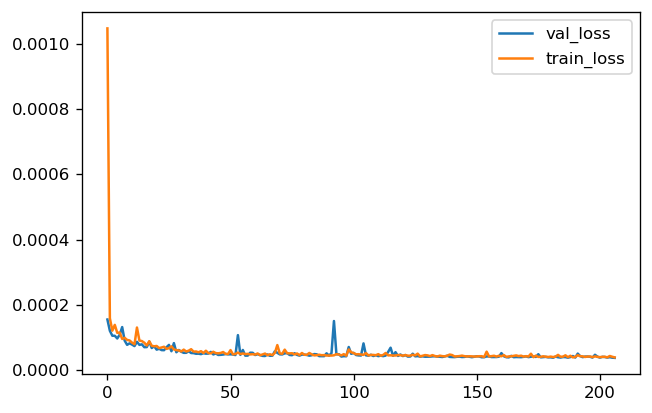

In [52]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>產生假圖</h3>

In [53]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

encoded_imgs = encoder.predict(x_test)
print(encoded_imgs.shape)

encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), max_dim[0], max_dim[1], 1))

(1122, 32, 32, 64)


In [54]:
decoded_imgs = autoencoder.predict(x_test)

In [55]:
x_test.shape, encoded_imgs.shape, decoded_imgs.shape

((1122, 256, 256, 3), (1122, 256, 256, 1), (1122, 256, 256, 3))

<h3>隨機顯示抽象圖與假圖</h3>

In [56]:
i = numpy.random.randint(0, x_test.shape[0], 1)[0]

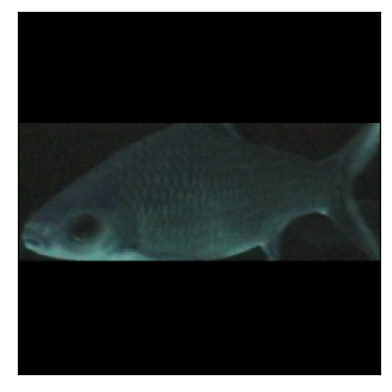

In [57]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(x_test[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


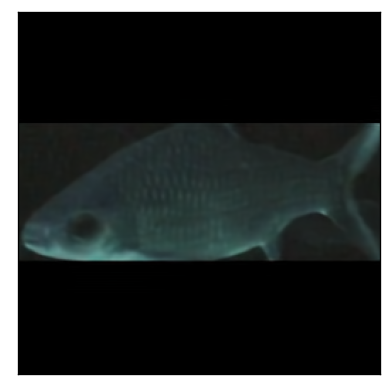

In [58]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

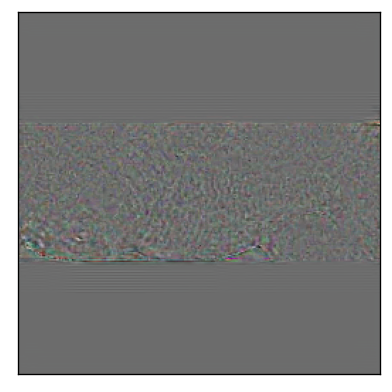

In [59]:
fig, ax = plt.subplots(dpi=120)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

<h3>顯示原圖與假圖</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


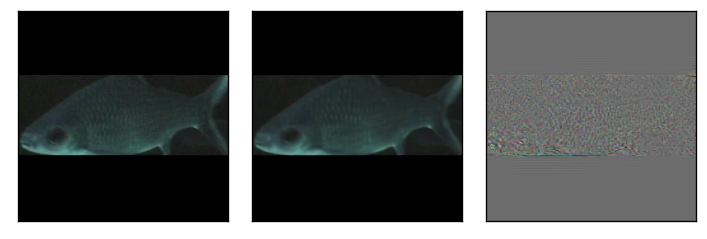

In [60]:
fig, (ax0, ax2, ax3) = plt.subplots(dpi=120, ncols=3)

ax0.imshow(x_test[i].reshape(max_dim), cmap=plt.cm.binary)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax2.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax3.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [61]:
def benchmark(my_diff_image):
    diff = 0.0
    
    for i in range(3):
        diff += numpy.sum(numpy.square(diff_image[i]))
        
    return diff**0.5

In [62]:
benchmark(diff_image)

0.011296237979319954

<h3>重建高雜訊圖</h3>

In [63]:
faint_image_files = glob('%s/F*.jpg' % 'images/objects/faint')

In [64]:
my_faint_images = []

for image_file in faint_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file, enhance_flag)

    my_faint_images.append(numpy.reshape(_fish_image, max_dim))

my_faint_images = numpy.array(my_faint_images)

In [65]:
my_faint_images = my_faint_images.astype('float32') / 255.
my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0],) + max_dim)

In [66]:
my_faint_images.shape

(24, 256, 256, 3)

<h3>產生假圖</h3>

In [76]:
encoding_dim = (32, 32, 64)

In [68]:
faint_encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

faint_encoded_imgs = faint_encoder.predict(my_faint_images)
faint_encoded_imgs = faint_encoded_imgs.reshape((len(faint_encoded_imgs), max_dim[0], max_dim[1], 1))

In [69]:
faint_decoded_imgs = autoencoder.predict(my_faint_images)

<h3>顯示原圖與假圖</h3>

In [70]:
def find_faint_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = faint_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

In [71]:
i = find_faint_file_pos()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


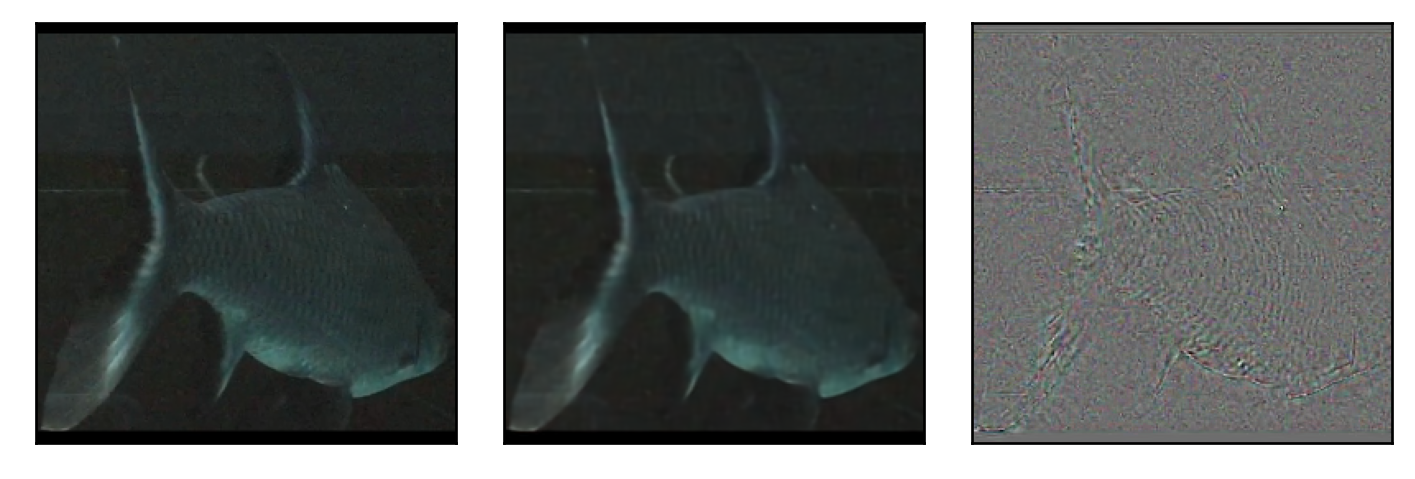

In [72]:
fig, (ax0, ax1, ax2) = plt.subplots(dpi=240, ncols=3)

ax0.imshow(my_faint_images[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(faint_decoded_imgs[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax2.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [73]:
benchmark(faint_diff_image)

0.011296237979319954

<h3>重建全圖</h3>

In [74]:
full_image_files = glob('%s/F*.jpg' % 'images/full')

my_full_images = []

for image_file in full_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file, enhance_flag)

    my_full_images.append(numpy.reshape(_fish_image, max_dim))

my_full_images = numpy.array(my_full_images)

my_full_images = my_full_images.astype('float32') / 255.
my_full_images = numpy.reshape(my_full_images, (my_full_images.shape[0],) + max_dim)

In [75]:
my_faint_images.shape

(24, 256, 256, 3)

In [77]:
full_encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

full_encoded_imgs = full_encoder.predict(my_full_images)
full_encoded_imgs = full_encoded_imgs.reshape((len(full_encoded_imgs), max_dim[0], max_dim[1], 1))

full_decoded_imgs = autoencoder.predict(my_full_images)

In [78]:
def find_full_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_full_images.shape[0], 1)[0]
    else:
        for j in range(len(full_image_files)):
            image_file = full_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_full_images.shape[0], 1)[0]
        
    return pos

In [79]:
i = find_full_file_pos()

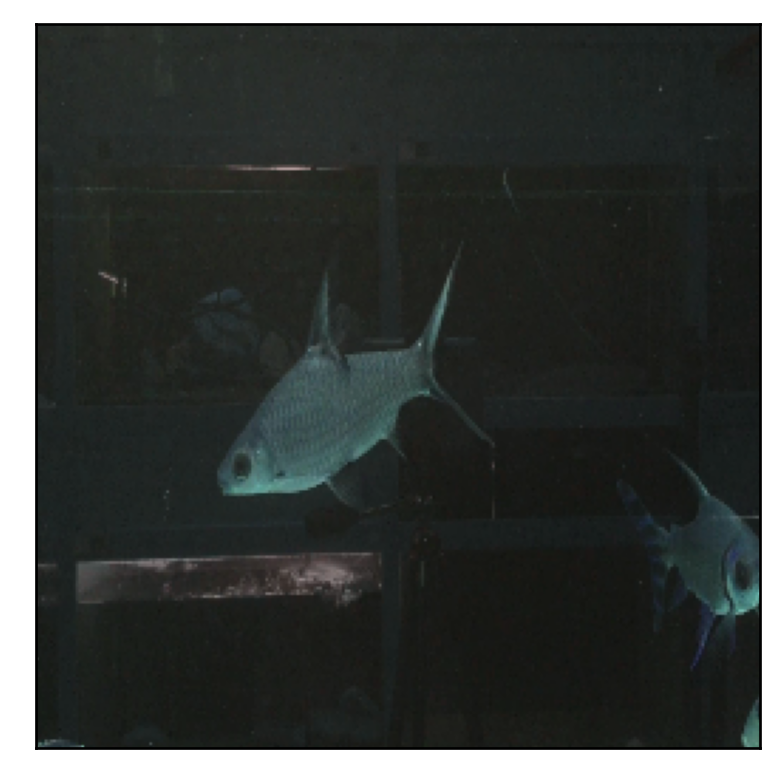

In [81]:
fig, ax0 = plt.subplots(dpi=240)

ax0.imshow(my_full_images[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

plt.show()

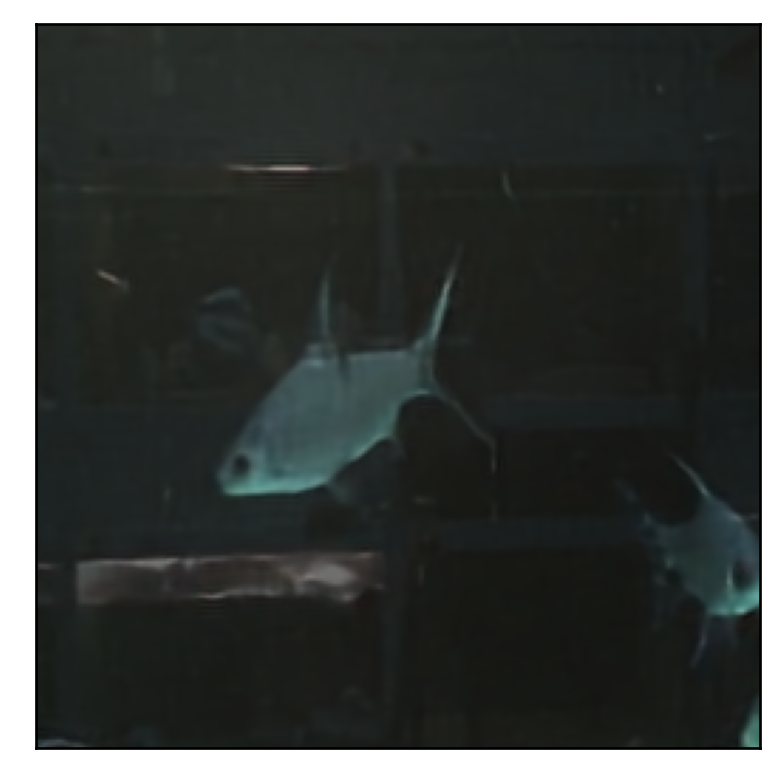

In [82]:
fig, ax1 = plt.subplots(dpi=240)

ax1.imshow(full_decoded_imgs[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

plt.show()

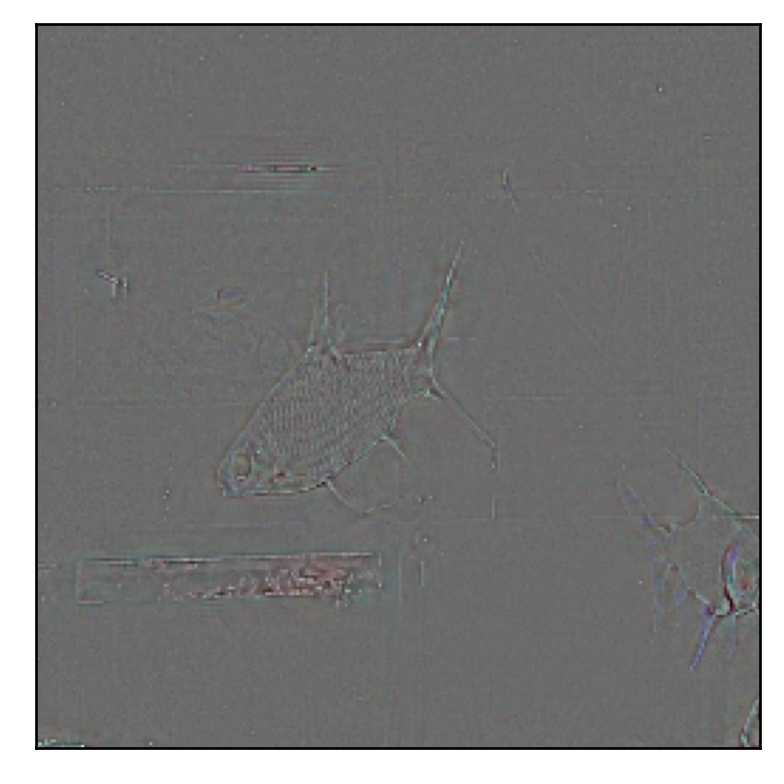

In [83]:
fig, ax2 = plt.subplots(dpi=240)

full_diff_image = my_full_images[i] - full_decoded_imgs[i]
full_diff_image_min = full_diff_image.min()
full_diff_image_max = full_diff_image.max()
full_diff_image_val = (full_diff_image - full_diff_image_min) / (full_diff_image_max - full_diff_image_min)

ax2.imshow(full_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()

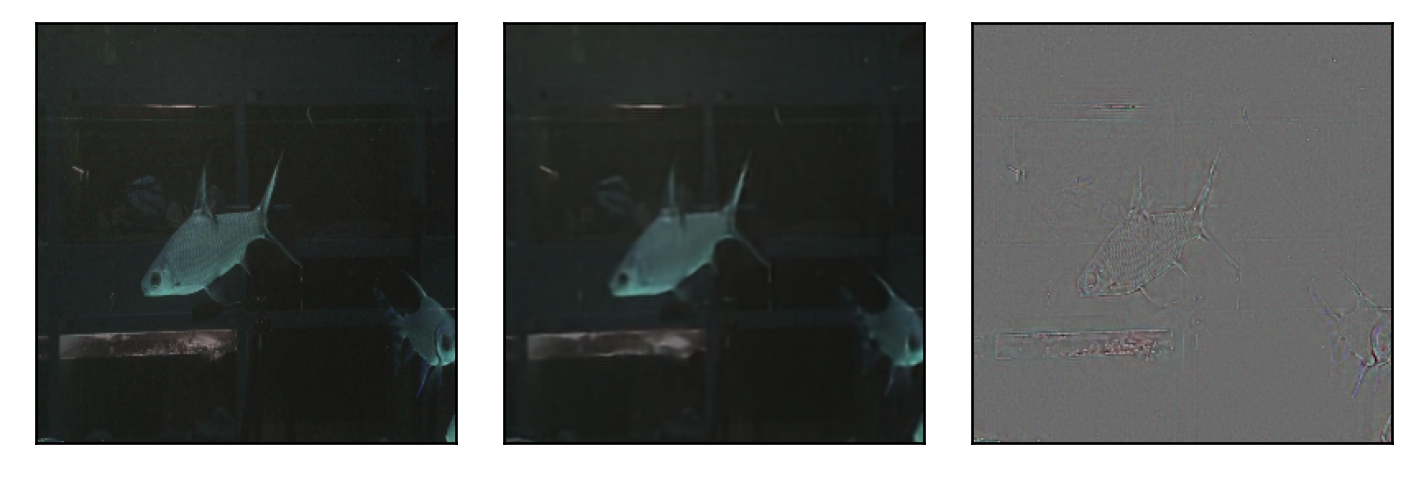

In [80]:
fig, (ax0, ax1, ax2) = plt.subplots(dpi=240, ncols=3)

ax0.imshow(my_full_images[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(full_decoded_imgs[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

full_diff_image = my_full_images[i] - full_decoded_imgs[i]
full_diff_image_min = full_diff_image.min()
full_diff_image_max = full_diff_image.max()
full_diff_image_val = (full_diff_image - full_diff_image_min) / (full_diff_image_max - full_diff_image_min)

ax2.imshow(full_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

<h3>重建其他魚圖</h3>

In [86]:
other_image_files = glob('%s/F*.*' % 'images/others')

my_other_images = []

for image_file in other_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file, enhance_flag)

    my_other_images.append(numpy.reshape(_fish_image, max_dim))

my_other_images = numpy.array(my_other_images)

my_other_images = my_other_images.astype('float32') / 255.
my_other_images = numpy.reshape(my_other_images, (my_other_images.shape[0],) + max_dim)

In [87]:
other_encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

other_encoded_imgs = other_encoder.predict(my_other_images)
other_encoded_imgs = other_encoded_imgs.reshape((len(other_encoded_imgs), max_dim[0], max_dim[1], 1))

other_decoded_imgs = autoencoder.predict(my_other_images)

In [88]:
def find_other_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_other_images.shape[0], 1)[0]
    else:
        for j in range(len(other_image_files)):
            image_file = other_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_other_images.shape[0], 1)[0]
        
    return pos

In [89]:
i = find_other_file_pos()

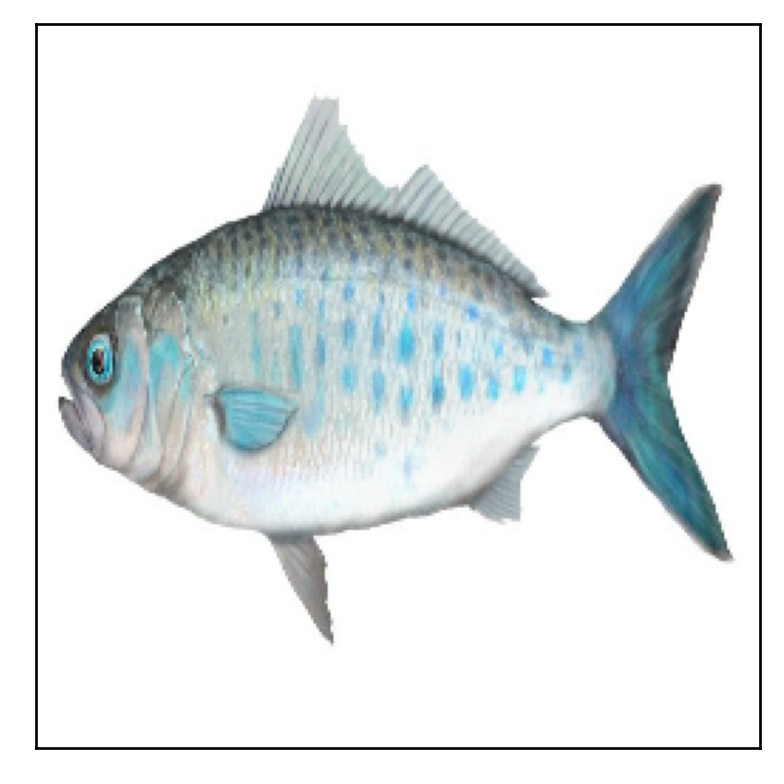

In [90]:
fig, ax0 = plt.subplots(dpi=240)

ax0.imshow(my_other_images[i].reshape(max_dim))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


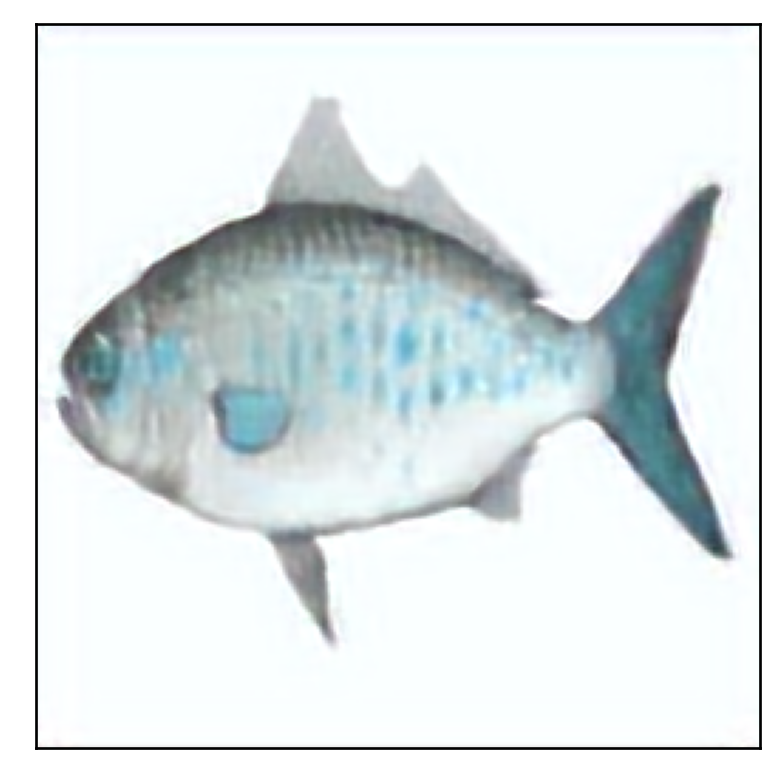

In [91]:
fig, ax1 = plt.subplots(dpi=240)

ax1.imshow(other_decoded_imgs[i].reshape(max_dim))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

plt.show()

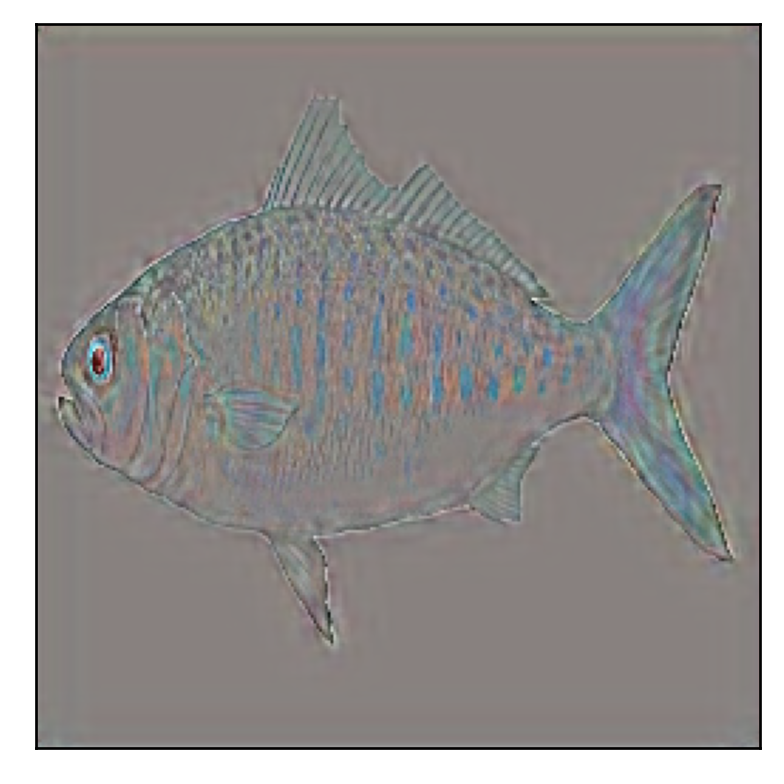

In [92]:
fig, ax2 = plt.subplots(dpi=240)

other_diff_image = my_other_images[i] - other_decoded_imgs[i]
other_diff_image_min = other_diff_image.min()
other_diff_image_max = other_diff_image.max()
other_diff_image_val = (other_diff_image - other_diff_image_min) / (other_diff_image_max - other_diff_image_min)

ax2.imshow(other_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()